In [1]:
from pyspark import SparkConf, SparkContext

In [2]:
conf = SparkConf().setMaster("local").setAppName("My App") # master：运行模式，默认local[*]

In [3]:
sc = SparkContext(conf = conf)

In [59]:
textfile = sc.textFile("C:/Project materials/CCB/tmp/lexisnexis_spark_test1.csv")

In [60]:
textfile.persist()

C:/Project materials/CCB/tmp/lexisnexis_spark_test1.csv MapPartitionsRDD[99] at textFile at NativeMethodAccessorImpl.java:0

In [61]:
%time lnRDD = textfile.map(lambda line:line.split('|')) # 文件的每一行按照“|”拆分

Wall time: 1 ms


In [62]:
%time lnRDD.count()

Wall time: 25.7 s


125322

In [63]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [64]:
header = lnRDD.first()

In [127]:
lnRDD_new = lnRDD.filter(lambda x: x != header)

In [76]:
%time df = lnRDD_new.toDF(header)

Wall time: 2.01 s


In [66]:
%time df.count()

Wall time: 1min 4s


125321

In [128]:
df.show(5)

+-------+--------------------+----------+--------+------+------+---+----------+--------+--------------+------------+-------------+----------------+------------+--------------------+--------------------+----------------+---+-------+--------------+-------------+--------------------+--------+----------+--------------------+--------------------+--------------------+----------+----------+----------+----+--------+--------+-----+-------------+-----------+-------------+------+-----------------+---------------------+
| ent_id|                name| firstname|lastname|prefix|suffix|aka|namesource|parentid|govdesignation|   entrytype|entrycategory|entrysubcategory|organization|           positions|             remarks|             dob|pob|country|expirationdate|effectivedate|         picturefile|linkedto|related_id|       sourceweblink|           touchdate|            directid|passportid|nationalid|   otherid|dob2|entlevel|masterid|watch|relationships|primaryname|originalname2|gender|ey_dailydelta

In [68]:
from pyspark.sql import SparkSession, Row
session = SparkSession.builder.getOrCreate()

In [69]:
df.registerTempTable("lexisnexis_temp_table") # 虚拟表

In [71]:
%time session.sql('select count(0) from lexisnexis_temp_table').show()

+--------+
|count(0)|
+--------+
|  125321|
+--------+

Wall time: 1min 3s


In [73]:
%time session.sql("select count(0) from lexisnexis_temp_table group by country").show()

+--------+
|count(0)|
+--------+
|     205|
|     382|
|       7|
|     170|
|     320|
|      12|
|     241|
|       3|
|      45|
|       7|
|     674|
|      48|
|       1|
|    1247|
|    1662|
|      43|
|     808|
|     395|
|      45|
|     462|
+--------+
only showing top 20 rows

Wall time: 1min 11s


增加计算列

In [86]:
lnRDD_new.map(lambda x: (x[2], x[3], x[0], x[1],int(x[0])+9999,x[1]+",你好")).take(5)

[('""',
  '""',
  '2384551',
  'Koneckie Zakłady Odlewnicze S.A.',
  2394550,
  'Koneckie Zakłady Odlewnicze S.A.,你好'),
 ('Guillaume',
  'Lambert',
  '2384703',
  'Lambert, Guillaume',
  2394702,
  'Lambert, Guillaume,你好'),
 ('Jacqueline',
  'Clauw',
  '2384825',
  'Clauw, Jacqueline',
  2394824,
  'Clauw, Jacqueline,你好'),
 ('Els', 'Vanheste', '2384826', 'Vanheste, Els', 2394825, 'Vanheste, Els,你好'),
 ('John',
  'Vanheste',
  '2384827',
  'Vanheste, John',
  2394826,
  'Vanheste, John,你好')]

In [85]:
df.select("name","ent_id","firstname","lastname", df.ent_id+9999, df.name+",你好").show(5)

+--------------------+-------+----------+--------+---------------+--------------+
|                name| ent_id| firstname|lastname|(ent_id + 9999)|(name + ,你好)|
+--------------------+-------+----------+--------+---------------+--------------+
|Koneckie Zakłady ...|2384551|        ""|      ""|      2394550.0|          null|
|  Lambert, Guillaume|2384703| Guillaume| Lambert|      2394702.0|          null|
|   Clauw, Jacqueline|2384825|Jacqueline|   Clauw|      2394824.0|          null|
|       Vanheste, Els|2384826|       Els|Vanheste|      2394825.0|          null|
|      Vanheste, John|2384827|      John|Vanheste|      2394826.0|          null|
+--------------------+-------+----------+--------+---------------+--------------+
only showing top 5 rows



In [87]:
df[df.name,df.ent_id,df.firstname,df.lastname,df.ent_id+9999,df.name+",你好"].show(5)

+--------------------+-------+----------+--------+---------------+--------------+
|                name| ent_id| firstname|lastname|(ent_id + 9999)|(name + ,你好)|
+--------------------+-------+----------+--------+---------------+--------------+
|Koneckie Zakłady ...|2384551|        ""|      ""|      2394550.0|          null|
|  Lambert, Guillaume|2384703| Guillaume| Lambert|      2394702.0|          null|
|   Clauw, Jacqueline|2384825|Jacqueline|   Clauw|      2394824.0|          null|
|       Vanheste, Els|2384826|       Els|Vanheste|      2394825.0|          null|
|      Vanheste, John|2384827|      John|Vanheste|      2394826.0|          null|
+--------------------+-------+----------+--------+---------------+--------------+
only showing top 5 rows



In [91]:
session.sql('select ent_id, lastname, firstname,name,ent_id+9999,concat(name, ",你好") from lexisnexis_temp_table').show(5)

+-------+--------+----------+--------------------+-----------------------------------------------+----------------------+
| ent_id|lastname| firstname|                name|(CAST(ent_id AS DOUBLE) + CAST(9999 AS DOUBLE))|   concat(name, ,你好)|
+-------+--------+----------+--------------------+-----------------------------------------------+----------------------+
|2384551|      ""|        ""|Koneckie Zakłady ...|                                      2394550.0|  Koneckie Zakłady ...|
|2384703| Lambert| Guillaume|  Lambert, Guillaume|                                      2394702.0|  Lambert, Guillaum...|
|2384825|   Clauw|Jacqueline|   Clauw, Jacqueline|                                      2394824.0|Clauw, Jacqueline,你好|
|2384826|Vanheste|       Els|       Vanheste, Els|                                      2394825.0|    Vanheste, Els,你好|
|2384827|Vanheste|      John|      Vanheste, John|                                      2394826.0|   Vanheste, John,你好|
+-------+--------+----------+---

In [90]:
sqlContext.sql("""
    select ent_id, lastname, firstname,name,ent_id+9999,concat(name, ",你好") from lexisnexis_temp_table
""").show(5)

+-------+--------+----------+--------------------+-----------------------------------------------+----------------------+
| ent_id|lastname| firstname|                name|(CAST(ent_id AS DOUBLE) + CAST(9999 AS DOUBLE))|   concat(name, ,你好)|
+-------+--------+----------+--------------------+-----------------------------------------------+----------------------+
|2384551|      ""|        ""|Koneckie Zakłady ...|                                      2394550.0|  Koneckie Zakłady ...|
|2384703| Lambert| Guillaume|  Lambert, Guillaume|                                      2394702.0|  Lambert, Guillaum...|
|2384825|   Clauw|Jacqueline|   Clauw, Jacqueline|                                      2394824.0|Clauw, Jacqueline,你好|
|2384826|Vanheste|       Els|       Vanheste, Els|                                      2394825.0|    Vanheste, Els,你好|
|2384827|Vanheste|      John|      Vanheste, John|                                      2394826.0|   Vanheste, John,你好|
+-------+--------+----------+---

过滤列

In [95]:
lnRDD.filter(lambda r: r[2]=='Richard' and r[0]=='2458873').collect()

[['2458873',
  'Gonzalez, Richard',
  'Richard',
  'Gonzalez',
  '""',
  '""',
  'Webb Killa,Webb',
  'US-DEA',
  '0',
  '""',
  'Individual',
  'Enforcement',
  'RICO',
  '""',
  'Charged with racketeering, drug trafficking, organized crime and murder.',
  'According to United States Attorney - Southern District of New York and U.S. Drug Enforcement Administration; December 12, 2012: On December 12, 2012, the unsealing of a Superseding Indictment charged 40 members and associates of the Bronx Trinitarios Gang (“BTG”) with racketeering, murder, attempted murder, narcotics, and firearms offenses. The original Indictment, filed in December 2011 against 50 members of BTG, alleged that the gang operated as a Racketeer Influenced and Corrupt Organization (RICO) and was responsible for certain narcotics and firearms trafficking offenses. The superseding indictment against 26 new defendants and 14 already charged, adds additional racketeering offenses and violent crimes including nine murders

In [96]:
df.filter("firstname='Richard' and ent_id='2458873'").show()

+-------+-----------------+---------+--------+------+------+---------------+----------+--------+--------------+----------+-------------+----------------+------------+--------------------+--------------------+----+---+-------------+--------------+-------------+-----------+--------+----------+--------------------+--------------------+--------------------+----------+----------+-------+----+--------+--------+-----+-------------+-----------+-------------+------+-----------------+---------------------+
| ent_id|             name|firstname|lastname|prefix|suffix|            aka|namesource|parentid|govdesignation| entrytype|entrycategory|entrysubcategory|organization|           positions|             remarks| dob|pob|      country|expirationdate|effectivedate|picturefile|linkedto|related_id|       sourceweblink|           touchdate|            directid|passportid|nationalid|otherid|dob2|entlevel|masterid|watch|relationships|primaryname|originalname2|gender|ey_dailydeltadate|ey_dailydeltafilena

In [97]:
df.filter("firstname='Richard'").filter("ent_id='2458873'").show() # spark过滤器

+-------+-----------------+---------+--------+------+------+---------------+----------+--------+--------------+----------+-------------+----------------+------------+--------------------+--------------------+----+---+-------------+--------------+-------------+-----------+--------+----------+--------------------+--------------------+--------------------+----------+----------+-------+----+--------+--------+-----+-------------+-----------+-------------+------+-----------------+---------------------+
| ent_id|             name|firstname|lastname|prefix|suffix|            aka|namesource|parentid|govdesignation| entrytype|entrycategory|entrysubcategory|organization|           positions|             remarks| dob|pob|      country|expirationdate|effectivedate|picturefile|linkedto|related_id|       sourceweblink|           touchdate|            directid|passportid|nationalid|otherid|dob2|entlevel|masterid|watch|relationships|primaryname|originalname2|gender|ey_dailydeltadate|ey_dailydeltafilena

In [100]:
df.filter((df.firstname=='Richard') & (df.ent_id=='2458873')).show() # pandas,dataframe风格

+-------+-----------------+---------+--------+------+------+---------------+----------+--------+--------------+----------+-------------+----------------+------------+--------------------+--------------------+----+---+-------------+--------------+-------------+-----------+--------+----------+--------------------+--------------------+--------------------+----------+----------+-------+----+--------+--------+-----+-------------+-----------+-------------+------+-----------------+---------------------+
| ent_id|             name|firstname|lastname|prefix|suffix|            aka|namesource|parentid|govdesignation| entrytype|entrycategory|entrysubcategory|organization|           positions|             remarks| dob|pob|      country|expirationdate|effectivedate|picturefile|linkedto|related_id|       sourceweblink|           touchdate|            directid|passportid|nationalid|otherid|dob2|entlevel|masterid|watch|relationships|primaryname|originalname2|gender|ey_dailydeltadate|ey_dailydeltafilena

In [101]:
df.filter((df["firstname"]=='Richard') & (df["ent_id"]=='2458873')).show() # pandas,dataframe风格

+-------+-----------------+---------+--------+------+------+---------------+----------+--------+--------------+----------+-------------+----------------+------------+--------------------+--------------------+----+---+-------------+--------------+-------------+-----------+--------+----------+--------------------+--------------------+--------------------+----------+----------+-------+----+--------+--------+-----+-------------+-----------+-------------+------+-----------------+---------------------+
| ent_id|             name|firstname|lastname|prefix|suffix|            aka|namesource|parentid|govdesignation| entrytype|entrycategory|entrysubcategory|organization|           positions|             remarks| dob|pob|      country|expirationdate|effectivedate|picturefile|linkedto|related_id|       sourceweblink|           touchdate|            directid|passportid|nationalid|otherid|dob2|entlevel|masterid|watch|relationships|primaryname|originalname2|gender|ey_dailydeltadate|ey_dailydeltafilena

In [114]:
df.select("name","ent_id","firstname","lastname").orderBy(["ent_id","name"],ascendng=[0,1]).show(5)

+--------------------+---------+--------------+----------------+
|                name|   ent_id|     firstname|        lastname|
+--------------------+---------+--------------+----------------+
|Gutiérrez Uceta, ...| 10000035|       Agustín| Gutiérrez Uceta|
|        Hennies, Tom|100000411|           Tom|         Hennies|
|Betances Álvarez,...| 10000044|      Leonardo|Betances Álvarez|
|De León Serrano, ...| 10000060|        Rafael| De León Serrano|
|Díaz Troncoso, Ys...| 10000078|Ysamel Antonio|   Díaz Troncoso|
+--------------------+---------+--------------+----------------+
only showing top 5 rows



In [112]:
lnRDD_new.takeOrdered(3, key = lambda x: (-int(x[0]),x[1])) # 按照ent_id降序、name升序排列

[['225178025',
  "PUBLIC JOINT STOCK COMPANY 'OIL COMPANY LUKOIL'",
  '""',
  '""',
  '""',
  '""',
  '""',
  'UA-NSDC',
  '0',
  '""',
  'Organization',
  'Associated Entity',
  'SWIFT BIC Entity',
  '""',
  'Branch/operational unit of Public Joint Stock Company Oil Company LUKOIL, a sanctioned entity.',
  'BIC data used with permission of S.W.I.F.T. SCRL. Database rights reserved 2017.',
  '""',
  '""',
  'Russian Federation',
  '""',
  '""',
  '""',
  '""',
  '0',
  'https://www.swift.com/',
  '7/18/2020 11:01:25 AM',
  'e23616b2-83ce-4a42-854b-b8be845f4725',
  'LUKORUM1XXX',
  '""',
  '""',
  '""',
  'N/A',
  '0',
  '0',
  '1',
  '""',
  '""',
  '""',
  '2020-07-20',
  './ErnstYoungChinaAdvisory/2020-07-20/WorldCompliance_2020-07-20.zip_files\\WorldCompliance_2020-07-20.xml'],
 ['225178024',
  'NOVOSIBIRSK BRANCH',
  '""',
  '""',
  '""',
  '""',
  '""',
  'UA-NSDC',
  '225178023',
  '""',
  'Organization',
  'Associated Entity',
  'SWIFT BIC Entity',
  '""',
  'Branch/operational 

In [115]:
df.select("name","ent_id","firstname","lastname").orderBy(df.ent_id.desc(),df.name.asc()).show(5)

+--------------------+-------+--------------+-----------------+
|                name| ent_id|     firstname|         lastname|
+--------------------+-------+--------------+-----------------+
|Márquez Sánchez, ...|9999994|      Bernardo|  Márquez Sánchez|
|   TempbrosCo., Ltd.|9999831|            ""|               ""|
|Fajardo Genao, Da...|9999813|        Danilo|    Fajardo Genao|
|Persol Tempstaff ...|9999760|            ""|               ""|
|Ventura Rodríguez...|9999555|Vianny Lozania|Ventura Rodríguez|
+--------------------+-------+--------------+-----------------+
only showing top 5 rows



数据去重

In [116]:
lnRDD_new.map(lambda x:x[18]).distinct().collect()

['Poland',
 'Argentina',
 'Norway',
 'Uzbekistan',
 'United States',
 'Denmark',
 'Saudi Arabia',
 'Iran',
 'Pakistan',
 'Mexico',
 'Finland',
 'Syrian Arab Republic',
 'Ukraine',
 'Guatemala',
 'Netherlands',
 'Isle of Man',
 'South Africa',
 'Kenya',
 'Switzerland',
 'Cape Verde',
 'Botswana',
 'Hungary',
 'Mauritius',
 'Kosovo',
 'Mauritania',
 'Maldives',
 'Ethiopia',
 'Bermuda',
 'Aruba',
 'Equatorial Guinea',
 'Germany',
 'Korea, Republic Of',
 'Canada',
 'Bulgaria',
 'Spain',
 'Singapore',
 'Niger',
 'Zimbabwe',
 'United Arab Emirates',
 'Afghanistan',
 'Romania',
 'St. Pierre & Miquelon',
 'Dominican Republic',
 'Madagascar',
 'Panama',
 'Egypt',
 'Jamaica',
 'Yemen',
 'Bolivia',
 'Belarus',
 'Seychelles',
 'Jordan',
 'Gambia',
 'Sao Tome & Principe',
 'Guadeloupe',
 'Benin',
 'Europe',
 'Martinique',
 'Guam',
 'St. Lucia',
 'Northern Mariana Islands',
 'India',
 'Somalia',
 'Angola',
 'Algeria',
 'Ireland',
 'Portugal',
 'Macedonia',
 'Nigeria',
 'Suriname',
 'Montenegro',
 'C

In [119]:
lnRDD_new.map(lambda x:(x[1],x[18])).distinct().collect()

[('Vanheste, John', 'Belgium'),
 ('Trivedi, Narendrabhai Chotelal', 'India'),
 ('Chudasma, Chandrikabahen Kanjibhai', 'India'),
 ('Chudasma, Kanjibhai', 'India'),
 ('De Pedro, Eduardo Enrique', 'Argentina'),
 ('Tôn, Hạnh Thị Ngọc', 'Vietnam'),
 ('Scott, Daniel P', 'United States'),
 ('Chaudhari, Sitabahen Bhemabhai', 'India'),
 ('Weißgerber, Franziska', 'Germany'),
 ('Ocampo Marin, Luis Alfonso', 'Colombia'),
 ('Lemos dos Santos, Eduardo Breno', 'Angola'),
 ('Tchipinge, João Marcelino', 'Angola'),
 ('Chipimo, Elias C.', 'Zambia'),
 ('Schneider, Manfred', 'Germany'),
 ('Osborn, Alan John', 'United Kingdom'),
 ('Holz, Manfred', 'Norway'),
 ('de Fontes Pereira, Manuel', 'Angola'),
 ('Al Sabah, Sheikha Ahmad Nasser Al Mohammed', 'Kuwait'),
 ('Bedoui, Noureddine', 'Algeria'),
 ('Farmonovich, Omonov Hasan', 'Uzbekistan'),
 ('Arregi Romarate, Amaia', 'Spain'),
 ('Govier, Andrew James', 'United Kingdom'),
 ('Sobirov, Ilgizar Matyoqubovich', 'Uzbekistan'),
 ('Abu-Jabal', 'Saudi Arabia'),
 ('Chi

In [120]:
df.select("name", "country").distinct().show() # 去重复

+--------------------+--------------------+
|                name|             country|
+--------------------+--------------------+
|   Metgud, Snehalata|               India|
|Shalayev, Ayndi Z...|  Russian Federation|
|      Kim, Chun-song|Korea, Democratic...|
|   Tenney, Rosemarie|       United States|
|     Huppert, Janice|           Australia|
|Hyundai Marine an...|  Korea, Republic Of|
|     Rangel, Michael|       United States|
|  Gonzalez, Geovanni|       United States|
|Russell Acquisiti...|               Japan|
|      Larsen, Renate|              Norway|
|www.mitsubishifin...|               Japan|
|Smedsrud Skeid, B...|              Norway|
|       Shtjefni, Zef|             Albania|
|Tsvangirai, Milli...|            Zimbabwe|
|         Wen, Tiejun|               China|
|      Qadhafi, Aisha|               Libya|
|Afri Belg Commerc...|              Angola|
|Méndez Hurtado, R...|            Colombia|
|     Zwanziger, Theo|         Switzerland|
|        Šipoš, Atila|          

分组统计

In [124]:
df.stat.crosstab('country','entrycategory').show(20) # 交叉表，相当于pandas中的透视表，相当于一个复杂的分组

+---------------------+-------------+-----------------+-----------+---+---+-------------+
|country_entrycategory|Adverse Media|Associated Entity|Enforcement|PEP|SOE|Sanction List|
+---------------------+-------------+-----------------+-----------+---+---+-------------+
| Taiwan, Province ...|          160|                0|        115|629| 92|            0|
|                Haiti|            6|                0|          0|  8|  0|            0|
| Macao Special Adm...|            7|                0|          0| 14|  1|            0|
|              Vanuatu|            0|                0|          4|  3|  0|            0|
|                 Iraq|            3|                1|          1| 86|  0|          371|
|          South Sudan|            0|                0|          0| 71|  1|            7|
|               Poland|            3|                2|         71|315| 71|            0|
|          Timor-Leste|            0|                0|          0|  2|  0|            0|
|         

In [125]:
df.select("country","entrycategory").groupBy("country", "entrycategory").count().orderBy("country", "entrycategory").show(20)

+--------------+-----------------+-----+
|       country|    entrycategory|count|
+--------------+-----------------+-----+
|   Afghanistan|    Adverse Media|    3|
|   Afghanistan|      Enforcement|    2|
|   Afghanistan|              PEP|  959|
|   Afghanistan|              SOE|    3|
|   Afghanistan|    Sanction List|  435|
|       Albania|    Adverse Media|   72|
|       Albania|      Enforcement|  155|
|       Albania|              PEP|  213|
|       Albania|              SOE|    1|
|       Algeria|    Adverse Media|    7|
|       Algeria|Associated Entity|    2|
|       Algeria|      Enforcement|    2|
|       Algeria|              PEP|  287|
|       Algeria|              SOE|    2|
|       Algeria|    Sanction List|  129|
|American Samoa|              SOE|    1|
|       Andorra|    Adverse Media|    3|
|       Andorra|      Enforcement|    2|
|       Andorra|              PEP|   27|
|       Andorra|              SOE|    6|
+--------------+-----------------+-----+
only showing top

In [126]:
df.describe().show() # 分组统计数据

+-------+-------------------+------------------------------------+-----------+---------+--------------------+------+------------------+----------+--------------------+--------------+---------+-------------+----------------+------------+--------------------+-------------------------------------+------------------+--------------------+-----------+------------------+------------------+--------------------+--------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------+----------------+--------------------+------------------+-------------------------------------+--------------------+------+-----------------+---------------------+
|summary|             ent_id|                                name|  firstname| lastname|              prefix|suffix|               aka|namesource|            parentid|govdesignation|entrytype|entrycategory|entrysubcategory|organization|       

join关联数据

In [129]:
csvfile = sc.textFile("Desktop/lexisnexis_pg_test.csv")

In [130]:
header = csvfile.first()
testRDD = csvfile.filter(lambda x: x != header)

In [131]:
testRDD_new = testRDD.map(lambda x: x.replace("\"", ""))

In [132]:
testRDD = testRDD_new.map(lambda x: x.split(","))

In [133]:
testRDD.first()

['1574372',
 'Skvortsova',
 ' Veronika Igorevna',
 'Veronika Igorevna',
 'Skvortsova',
 '',
 '',
 '',
 'Website',
 '0',
 '',
 'Individual',
 'PEP',
 'Govt Branch Member',
 '',
 'Head of the Federal Biomedical Agency',
 ' effective from January 22',
 ' 2020.',
 'Career: Head',
 ' effective from January 22',
 ' 2020',
 ' Agency: Federal Biomedical Agency; Head of the Federal Service for Surveillance in Healthcare (Roszdravnadzor)',
 ' effective from January 21',
 ' 2020; Member of the Supervisory Board of the State Corporation Rostec',
 ' effective from September 2018; Acting Minister of Healthcare (January 15',
 ' 2020 - January 21',
 ' 2020); Member of the Executive Board of the World Health Organization (2014 - 2017); Minister of Healthcare (May 21',
 ' 2012 - January 15',
 ' 2020); Deputy Minister of Healthcare and Social Development (July 15',
 ' 2008 - May 22',
 ' 2012).  Company name: State Corporation Rostec.',
 'November 01',
 ' 1960',
 'Moscow',
 ' ',
 ' Russia',
 'Russian Fede

In [134]:
testRDD.count()

125321

In [156]:
test_data = testRDD.map(lambda p:
                    Row(
                        ent_id=int(p[0]),
                        name=p[1],
                        entrytype=p[11],
                        entrycategory=p[12],
                        entrysubcategory=p[13],
                        positions=p[15]
                    )
                   )

In [151]:
test_data.take(5)

[Row(ent_id=1574372, entrycategory='PEP', entrysubcategory='Govt Branch Member', entrytype='Individual', name='Skvortsova', positions='Head of the Federal Biomedical Agency'),
 Row(ent_id=1574701, entrycategory='PEP', entrysubcategory='Govt Branch Member', entrytype='Individual', name='Alperovich', positions='Member of the National Congress (December 10'),
 Row(ent_id=1575309, entrycategory='Enforcement', entrysubcategory='Bank Fraud', entrytype='Individual', name='Erwin', positions='Sentenced to 120 months in prison for forgery and bank fraud - January 13'),
 Row(ent_id=1575311, entrycategory='Enforcement', entrysubcategory='Bank Fraud', entrytype='Individual', name='Bruce', positions='Sentenced to 41 months in prison for forgery and bank fraud - January 09'),
 Row(ent_id=1575314, entrycategory='Enforcement', entrysubcategory='Bank Fraud', entrytype='Individual', name='Wilson', positions='Sentenced to 65 months in prison for forgery and bank fraud - March 02')]

In [157]:
test_df = session.createDataFrame(test_data)

In [154]:
test_df.printSchema()

root
 |-- ent_id: long (nullable = true)
 |-- entrycategory: string (nullable = true)
 |-- entrysubcategory: string (nullable = true)
 |-- entrytype: string (nullable = true)
 |-- name: string (nullable = true)
 |-- positions: string (nullable = true)



In [160]:
test_df_table = test_df.registerTempTable("test_table")

In [161]:
sqlContext.sql("select * from test_table").show(5)

+-------+-------------+------------------+----------+----------+--------------------+
| ent_id|entrycategory|  entrysubcategory| entrytype|      name|           positions|
+-------+-------------+------------------+----------+----------+--------------------+
|1574372|          PEP|Govt Branch Member|Individual|Skvortsova|Head of the Feder...|
|1574701|          PEP|Govt Branch Member|Individual|Alperovich|Member of the Nat...|
|1575309|  Enforcement|        Bank Fraud|Individual|     Erwin|Sentenced to 120 ...|
|1575311|  Enforcement|        Bank Fraud|Individual|     Bruce|Sentenced to 41 m...|
|1575314|  Enforcement|        Bank Fraud|Individual|    Wilson|Sentenced to 65 m...|
+-------+-------------+------------------+----------+----------+--------------------+
only showing top 5 rows



In [162]:
test_df2 = df.select("ent_id","name","country","dob")

In [163]:
test_df2.show(5)

+-------+--------------------+-------+----------------+
| ent_id|                name|country|             dob|
+-------+--------------------+-------+----------------+
|2384551|Koneckie Zakłady ...| Poland|              ""|
|2384703|  Lambert, Guillaume| France|January 16, 1970|
|2384825|   Clauw, Jacqueline|Belgium|              ""|
|2384826|       Vanheste, Els|Belgium|            1977|
|2384827|      Vanheste, John|Belgium|            1982|
+-------+--------------------+-------+----------------+
only showing top 5 rows



In [164]:
joined_df = test_df.join(test_df2, test_df.ent_id == test_df2.ent_id, "left_outer")
joined_df.show(5)

+------+-------------+----------------+----------+--------------------+--------------------+------+--------------------+--------------------+--------------+
|ent_id|entrycategory|entrysubcategory| entrytype|                name|           positions|ent_id|                name|             country|           dob|
+------+-------------+----------------+----------+--------------------+--------------------+------+--------------------+--------------------+--------------+
| 15375|          PEP|      Former PEP|Individual|                Zīle|Former Member of ...| 15375|        Zīle, Monika|              Latvia| July 20, 1941|
| 92490|          PEP|      Former PEP|Individual|                  Li|Independent Non-E...| 92490|   Li, David Kwok-po|Hong Kong Special...|March 13, 1939|
|207297|          PEP|   Family Member|Individual|Pavlopoulou-Peltsemi|Wife of Prokopios...|207297|Pavlopoulou-Pelts...|              Greece|April 07, 1950|
|241649|          PEP|      Former PEP|Individual|        

In [165]:
test_df.join(test_df2, test_df.ent_id == test_df2.ent_id, "inner").show(5)

+------+-------------+----------------+----------+--------------------+--------------------+------+--------------------+--------------------+--------------+
|ent_id|entrycategory|entrysubcategory| entrytype|                name|           positions|ent_id|                name|             country|           dob|
+------+-------------+----------------+----------+--------------------+--------------------+------+--------------------+--------------------+--------------+
| 15375|          PEP|      Former PEP|Individual|                Zīle|Former Member of ...| 15375|        Zīle, Monika|              Latvia| July 20, 1941|
| 92490|          PEP|      Former PEP|Individual|                  Li|Independent Non-E...| 92490|   Li, David Kwok-po|Hong Kong Special...|March 13, 1939|
|207297|          PEP|   Family Member|Individual|Pavlopoulou-Peltsemi|Wife of Prokopios...|207297|Pavlopoulou-Pelts...|              Greece|April 07, 1950|
|241649|          PEP|      Former PEP|Individual|        

In [168]:
joined_df.filter('country="China"').groupby('country').count().show()

+-------+-----+
|country|count|
+-------+-----+
|  China|33251|
+-------+-----+



In [169]:
groupby_df = joined_df.groupby('country').count()

使用pandas可视化

In [170]:
p_df = groupby_df.toPandas().set_index('country',inplace=True)

In [171]:
p_df.T # 转置

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
country,Chad,Paraguay,Anguilla,International,Yemen,Senegal,Sweden,Kiribati,Guyana,Philippines,...,Vanuatu,Mauritius,Antigua & Barbuda,Syrian Arab Republic,United Kingdom,Moldova,Vietnam,Sao Tome & Principe,Netherlands,Mali
count,205,382,7,170,320,12,241,3,45,674,...,7,56,4,800,2326,100,1595,52,768,85


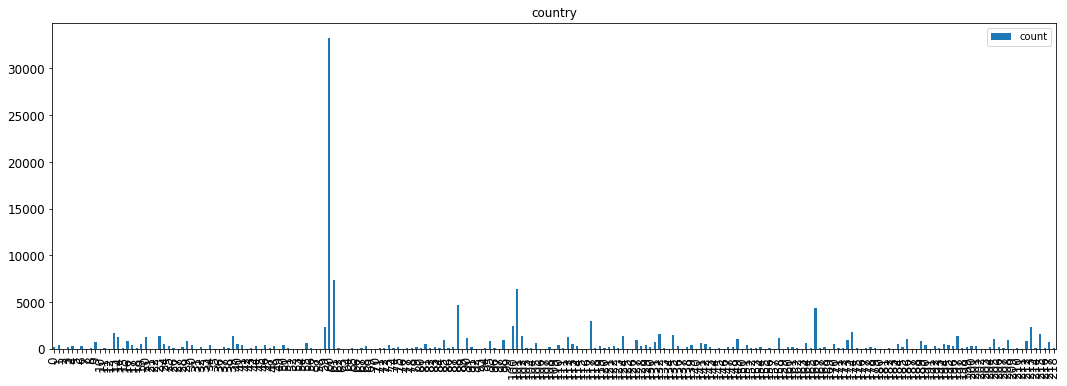

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = p_df['count'].plot(kind='bar', title='country',figsize=(18,6),legend=True,fontsize=12)
plt.show()

In [194]:
groupby_df1 = sqlContext.sql("select entrysubcategory, count(0) from test_table group by entrysubcategory")
groupby_df1.show()

+-------------------+--------+
|   entrysubcategory|count(0)|
+-------------------+--------+
|     Mgmt Govt Corp|    9300|
| Aircraft Hijacking|       1|
|             Doutor|       1|
|         Former PEP|   10474|
|Gambling Operations|     372|
|   Drug Trafficking|    3908|
|            Playboy|       1|
|   Financial Crimes|     339|
|        Tax Evasion|     206|
|                WMD|       4|
|                EPN|       1|
|           Debarred|     338|
|      Adverse Media|      94|
|     Administrative|     686|
|           Lollipop|       1|
|   Labor Violations|      22|
| Govt Branch Member|    7325|
|       Unauthorized|      76|
|               RICO|     200|
|   Healthcare Fraud|     174|
+-------------------+--------+
only showing top 20 rows



In [203]:
p_df1 = groupby_df1.toPandas().set_index("entrysubcategory", inplace=True)
p_df1.T

AttributeError: 'NoneType' object has no attribute 'T'

In [202]:
p_df1.plot(kind='pie', title='entrysubcategory',figsize=(8,8),startangle=90,autopct='%.1f%%')
plt.show()

AttributeError: 'NoneType' object has no attribute 'plot'